In [70]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision as tv
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt

In [71]:
# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [72]:
# Tranning data
train_data = datasets.FashionMNIST(
    root="Source/Dataset",
    download=True,
    train=True,
    transform=ToTensor(),
    target_transform=None
)

# Test data
test_data = datasets.FashionMNIST(
    root="Source/Dataset",
    download=True,
    train=False,
    transform=ToTensor(),
    target_transform=None
)

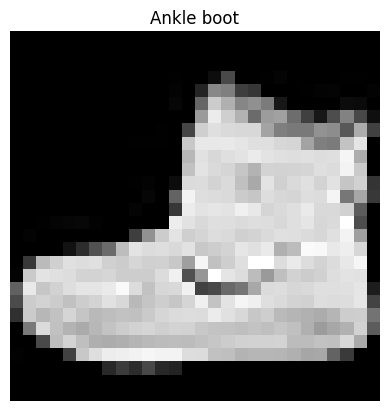

In [74]:
# Visualizing dataset
class_names = train_data.classes
image, title = train_data[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[title])
plt.axis(False)
plt.show()